In [1]:
import pandas as pd
import re
import csv
from collections import defaultdict
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
word_re = r'\b[a-zA-Z]+\b'
number_re = r'\b[0-9]+\b'
email_re = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
url_re = r'\b(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})\b'

In [3]:
train = pd.read_csv('train.csv')
train.head()

,party_affiliation,email_text,uid_email
0,Democratic Party,⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱...,3083493a6b205eabd8d0f1e7772db09b
1,Democratic Party,This new report needs your attention now. \n ...,3a583e28c820e1fac8902e4df0ef50e0
2,Democratic Party,<PARTY> <ORG> <ORG> <ORG> \n <> NEWS \n <PERS...,044219f46cca419d1d95242dfe036c15
3,Democratic Party,Chip in today to <GPE> to our virtual grassroo...,68059dd1d93d0cbf456763822d1ab680
4,Democratic Party,I ’m really sorry to bother you but I ’m not o...,9f41a878e2839dc013546e615da83efa


In [4]:
def tokenize(text):
    tokens = text.split()
    return tokens

In [5]:
stop_words = []
with open('stop_words.txt', 'rb') as txt:
    lines = txt.readlines()
    stop_words = [str(lines[i], 'utf-8', 'ignore').replace('\n', '') for i in range(len(lines))]

In [6]:
def better_tokenize(text):
    tokens = []
    words = text.split()
    for word in words:
        number = re.search(number_re, word)
        email = re.search(email_re, word)
        url = re.search(url_re, word)
        if number or email or url:
            continue

        match = re.findall(word_re, word)
        if match:
            token = match[0].lower()
            if len(token) == 1 or token in stop_words:
                continue

            tokens.append(token)
    return tokens

In [7]:
dict = defaultdict(int)
for index, row in train.iterrows():   
    tokens = better_tokenize(row[1])
    for token in tokens:
        dict[token] += 1

In [8]:
word_list = []
for key in dict:
    if dict[key] > 9:
        word_list.append(key)

In [9]:
x_i = []
x_v = []
for index, row in train.iterrows():
    tokens = better_tokenize(row[1])
    counter = Counter(tokens)
    for key in counter:
        if key in word_list:
            x_i.append([index, word_list.index(key)])
            x_v.append(counter[key])

X = torch.sparse_coo_tensor(torch.tensor(x_i).t(), x_v, (len(train), len(word_list)), dtype = torch.float32)

In [10]:
Y = []
for index, row in train.iterrows():
    if (row[0] == "Democratic Party"):
        Y.append([0])
    else:
        Y.append([1])

Y = torch.tensor(Y, dtype = torch.float32)

In [11]:
dev = pd.read_csv('dev.csv')
dev.head()

,party_affiliation,email_text,uid_email
0,Democratic Party,"<> <>, \n <DATE>, <> <PERSON> <PERSON> suspend...",64241625785edfde727dd84c08e5cda2
1,Democratic Party,We simply could not run our campaign without o...,d005af10b61a2565704c237fd506b5e9
2,Democratic Party,I have to give <> <> <PERSON> and the team an ...,75088c6211cca345172d18aab778b93c
3,Democratic Party,"Here ’s your challenge: Can we raise $ 10,000 ...",b56badd20bd35485b7197587333283d1
4,Democratic Party,"This week, I and more than 30 of my colleagues...",f60dc5576465f00970e35e36e57e9f1e


In [12]:
x_val_i = []
x_val_v = []
for index, row in dev.iterrows():
    tokens = better_tokenize(row[1])
    counter = Counter(tokens)
    for key in counter:
        if key in word_list:
            x_val_i.append([index, word_list.index(key)])
            x_val_v.append(counter[key])

X_val = torch.sparse_coo_tensor(torch.tensor(x_val_i).t(), x_val_v, (len(dev), len(word_list)), dtype = torch.float32)

In [13]:
Y_val = []
for index, row in dev.iterrows():
    if (row[0] == "Democratic Party"):
        Y_val.append([0])
    else:
        Y_val.append([1])

Y_val = torch.tensor(Y_val, dtype = torch.float32)

In [14]:
test = pd.read_csv('test.csv')
test.head()

,email_text,uid_email
0,"20,000 <GPE> <GPE> signatures needed \n 20,000...",5dfbe09ce5b500dd3dcb9f93c8fb185f
1,We 've worked way too hard and given way too m...,07e48f4183b98420a18503791fb412f6
2,If you use your 800%-MATCH \n <> \n <ORG> <OR...,b58c8607d96a414db0e9cc10108c35f5
3,"<PERSON>, a proposal for Vote- by- <> threaten...",3901d9539d69ada89e5c82e2f1ca950d
4,The <ORG> <ORG> <ORG> is under immediate threa...,6a3e8e6f31381e84a34571deee0f1238


In [15]:
uid = []
for index, row in test.iterrows():
    uid.append(row[1])

In [16]:
x_test_i = []
x_test_v = []
for index, row in test.iterrows():
    tokens = better_tokenize(row[0])
    counter = Counter(tokens)
    for key in counter:
        if key in word_list:
            x_test_i.append([index, word_list.index(key)])
            x_test_v.append(counter[key])

X_test = torch.sparse_coo_tensor(torch.tensor(x_test_i).t(), x_test_v, (len(test), len(word_list)), dtype = torch.float32)

In [17]:
class LogisticRegression(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(LogisticRegression, self).__init__()
        self.layer1 = nn.Linear(vocab_size, embedding_dim)
        self.layer2 = nn.Linear(embedding_dim, 1)
    
    def forward(self, inputs):
        d_inputs = self.layer1(inputs)
        out = torch.sigmoid(self.layer2(d_inputs))
        return out

In [18]:
class pytorchModule:
    def __init__(self, word_list, d, l_r=2e-5, w_d=0, opt="SGD"):
        self.loss_function = nn.BCELoss()
        self.model = LogisticRegression(len(word_list), d)
        if opt == "AdamW":
            self.optimizer = optim.AdamW(self.model.parameters(), lr = l_r, weight_decay=w_d)
        elif opt == "RMSprop":
            self.optimizer = optim.RMSprop(self.model.parameters(), lr = l_r, weight_decay=w_d)
        else:
            self.optimizer = optim.SGD(self.model.parameters(), lr = l_r, weight_decay=w_d)

    def train(self, f1_list, loss_list, X, Y, X_test, Y_test, PATH='./logistic_regrssion.pth', num_steps=1000, num_epochs=1, report_step=1000):
        max_f1_score = 0
        min_loss = 10000

        for epoch in range(num_epochs):

            indices = torch.randperm(X.shape[0])

            for step in tqdm(range(num_steps)):
                self.optimizer.zero_grad()

                outputs = self.model(X[indices[step]])
                        
                loss = self.loss_function(outputs, Y[indices[step]])

                loss.backward()

                self.optimizer.step()

                f1_score = self.eval(X_test, Y_test)
                
                if f1_score > max_f1_score or (f1_score >= max_f1_score and loss.item() < min_loss):
                    max_f1_score = f1_score
                    min_loss = loss.item()
                    if PATH != "":
                        torch.save(self.model.state_dict(), PATH)

                if (step + 1) % report_step == 0:
                    loss_list.append(loss.item())
                    f1_list.append(f1_score)

    def eval(self, X_test, Y_test):
        with torch.no_grad():
            Y_pred = self.model(X_test)
            Y_pred_class = Y_pred.round()

            precision = (torch.logical_and(Y_pred_class.eq(0), Y_test.eq(0)).sum()) / (Y_pred_class.eq(0).sum())
            recall = (torch.logical_and(Y_pred_class.eq(0), Y_test.eq(0)).sum()) / (Y_test.eq(0).sum())
            F1_score = 2 * (precision * recall) / (precision + recall)

            return F1_score.item()

    def load(self, PATH):
        self.model.load_state_dict(torch.load(PATH))


In [37]:
pytorch1 = pytorchModule(word_list=word_list, d=20, l_r=2e-5, w_d=0.01, opt="RMSprop")
f1_list_1 = [] 
loss_list_1 = []
pytorch1.train(f1_list_1, loss_list_1, X, Y, X_val, Y_val, '', 1000, 1, 100)

100%|██████████| 1000/1000 [02:58<00:00,  5.59it/s]


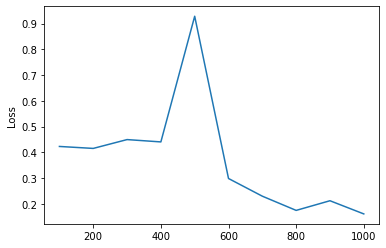

In [38]:
plt.plot([100*i for i in range(1, len(loss_list_1) + 1)], loss_list_1)
plt.ylabel('Loss')
plt.savefig('1-loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [63]:
pytorch2 = pytorchModule(word_list=word_list, d=20, l_r=2e-5, w_d=0.01, opt="RMSprop")
f1_list_2 = [] 
loss_list_2 = []
pytorch2.train(f1_list_2, loss_list_2, X, Y, X_val, Y_val, '', 5999, 5, 100)

100%|██████████| 5999/5999 [16:15<00:00,  6.15it/s]


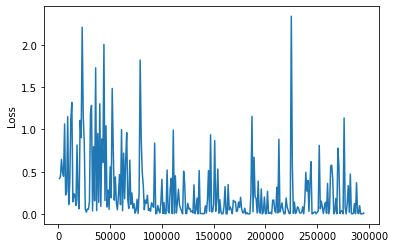

In [64]:
plt.plot([1000*i for i in range(1, len(loss_list_2) + 1)], loss_list_2)
plt.ylabel('Loss')
plt.savefig('2-loss.png', dpi=100, bbox_inches='tight')
plt.show()

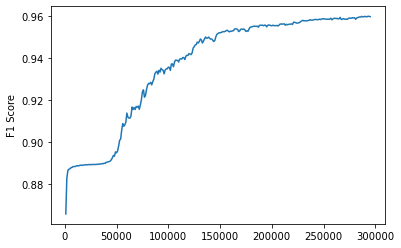

In [65]:
plt.plot([1000*i for i in range(1, len(f1_list_2) + 1)], f1_list_2)
plt.ylabel('F1 Score')
plt.savefig('2-f1.png', dpi=100, bbox_inches='tight')
plt.show()

In [41]:
pytorch3 = pytorchModule(word_list=word_list, d=20, l_r=2e-5, w_d=0, opt="SGD")
f1_list_3 = []
loss_list_3 = []
pytorch3.train(f1_list_3, loss_list_3, X, Y, X_val, Y_val, '', 5999, 1, 100)

100%|██████████| 5999/5999 [15:36<00:00,  6.40it/s]


In [68]:
pytorch4 = pytorchModule(word_list=word_list, d=20, l_r=2e-5, w_d=0.01, opt="SGD")
f1_list_4 = []
loss_list_4 = []
pytorch4.train(f1_list_4, loss_list_4, X, Y, X_val, Y_val, '', 5999, 1, 100)

100%|██████████| 5999/5999 [11:44<00:00,  8.52it/s]


In [69]:
pytorch5 = pytorchModule(word_list=word_list, d=20, l_r=2e-5, w_d=0.1, opt="SGD")
f1_list_5 = []
loss_list_5 = []
pytorch5.train(f1_list_5, loss_list_5, X, Y, X_val, Y_val, '', 5999, 1, 100)

100%|██████████| 5999/5999 [11:49<00:00,  8.45it/s]


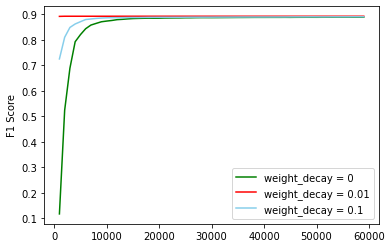

In [70]:
plt.plot([1000*i for i in range(1, len(f1_list_3) + 1)], f1_list_3, color='green', label='weight_decay = 0')
plt.plot([1000*i for i in range(1, len(f1_list_4) + 1)], f1_list_4, color='red', label='weight_decay = 0.01')
plt.plot([1000*i for i in range(1, len(f1_list_5) + 1)], f1_list_5, color='skyblue', label='weight_decay = 0.1')
plt.legend()
plt.ylabel('F1 Score')
plt.savefig('w_d-f1.png', dpi=100, bbox_inches='tight')
plt.show()

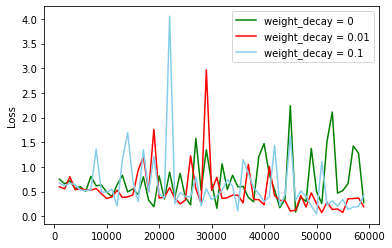

In [71]:
plt.plot([1000*i for i in range(1, len(loss_list_3) + 1)], loss_list_3, color='green', label='weight_decay = 0')
plt.plot([1000*i for i in range(1, len(loss_list_4) + 1)], loss_list_4, color='red', label='weight_decay = 0.01')
plt.plot([1000*i for i in range(1, len(loss_list_5) + 1)], loss_list_5, color='skyblue', label='weight_decay = 0.1')
plt.legend()
plt.ylabel('Loss')
plt.savefig('w_d-loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [46]:
pytorch6 = pytorchModule(word_list=word_list, d=20, l_r=2e-5, w_d=0, opt="RMSprop")
f1_list_6 = []
loss_list_6 = []
pytorch6.train(f1_list_6, loss_list_6, X, Y, X_val, Y_val, '', 5999, 1, 100)

100%|██████████| 5999/5999 [16:37<00:00,  6.02it/s]


In [47]:
pytorch7 = pytorchModule(word_list=word_list, d=20, l_r=2e-5, w_d=0, opt="AdamW")
f1_list_7 = []
loss_list_7 = []
pytorch7.train(f1_list_7, loss_list_7, X, Y, X_val, Y_val, '', 5999, 1, 100)

100%|██████████| 5999/5999 [17:14<00:00,  5.80it/s] 


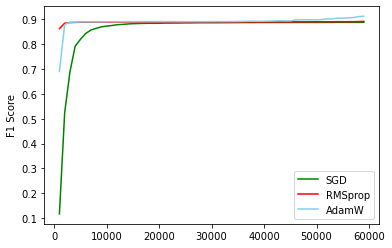

In [48]:
plt.plot([1000*i for i in range(1, len(f1_list_3) + 1)], f1_list_3, color='green', label='SGD')
plt.plot([1000*i for i in range(1, len(f1_list_6) + 1)], f1_list_6, color='red', label='RMSprop')
plt.plot([1000*i for i in range(1, len(f1_list_7) + 1)], f1_list_7, color='skyblue', label='AdamW')
plt.legend()
plt.ylabel('F1 Score')
plt.savefig('opt-f1.png', dpi=100, bbox_inches='tight')
plt.show()

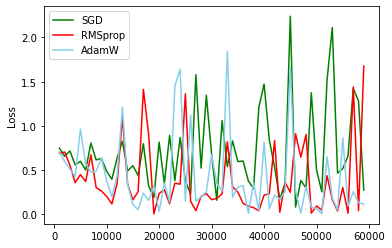

In [49]:
plt.plot([1000*i for i in range(1, len(loss_list_3) + 1)], loss_list_3, color='green', label='SGD')
plt.plot([1000*i for i in range(1, len(loss_list_6) + 1)], loss_list_6, color='red', label='RMSprop')
plt.plot([1000*i for i in range(1, len(loss_list_7) + 1)], loss_list_7, color='skyblue', label='AdamW')
plt.legend()
plt.ylabel('Loss')
plt.savefig('opt-loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [50]:
pytorch8 = pytorchModule(word_list=word_list, d=20, l_r=0.1, w_d=0, opt="SGD")
f1_list_8 = []
loss_list_8 = []
pytorch8.train(f1_list_8, loss_list_8, X, Y, X_val, Y_val, '', 5999, 1, 100)

100%|██████████| 5999/5999 [15:20<00:00,  6.52it/s]


In [72]:
pytorch9 = pytorchModule(word_list=word_list, d=20, l_r=1e-8, w_d=0, opt="SGD")
f1_list_9 = []
loss_list_9 = []
pytorch9.train(f1_list_9, loss_list_9, X, Y, X_val, Y_val, '', 5999, 1, 100)

100%|██████████| 5999/5999 [12:30<00:00,  7.99it/s]


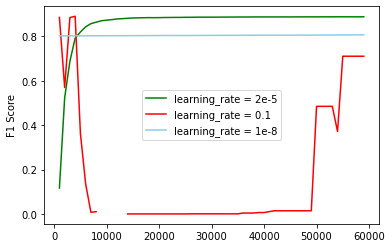

In [73]:
plt.plot([1000*i for i in range(1, len(f1_list_3) + 1)], f1_list_3, color='green', label='learning_rate = 2e-5')
plt.plot([1000*i for i in range(1, len(f1_list_8) + 1)], f1_list_8, color='red', label='learning_rate = 0.1')
plt.plot([1000*i for i in range(1, len(f1_list_9) + 1)], f1_list_9, color='skyblue', label='learning_rate = 1e-8')
plt.legend()
plt.ylabel('F1 Score')
plt.savefig('lr-f1.png', dpi=100, bbox_inches='tight')
plt.show()

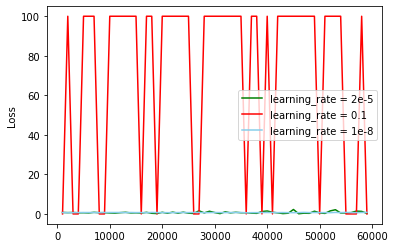

In [74]:
plt.plot([1000*i for i in range(1, len(loss_list_3) + 1)], loss_list_3, color='green', label='learning_rate = 2e-5')
plt.plot([1000*i for i in range(1, len(loss_list_8) + 1)], loss_list_8, color='red', label='learning_rate = 0.1')
plt.plot([1000*i for i in range(1, len(loss_list_9) + 1)], loss_list_9, color='skyblue', label='learning_rate = 1e-8')
plt.legend()
plt.ylabel('Loss')
plt.savefig('lr-loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [32]:
dict_2 = defaultdict(int)
for index, row in train.iterrows():   
    tokens = tokenize(row[1])
    for token in tokens:
        dict_2[token] += 1

In [33]:
word_list_2 = []
for key in dict_2:
    if dict_2[key] > 9:
        word_list_2.append(key)

In [34]:
x_i_2 = []
x_v_2 = []
for index, row in train.iterrows():
    tokens = tokenize(row[1])
    counter = Counter(tokens)
    for key in counter:
        if key in word_list_2:
            x_i_2.append([index, word_list_2.index(key)])
            x_v_2.append(counter[key])

X_2 = torch.sparse_coo_tensor(torch.tensor(x_i_2).t(), x_v_2, (len(train), len(word_list_2)), dtype = torch.float32)

In [35]:
x_val_i_2 = []
x_val_v_2 = []
for index, row in dev.iterrows():
    tokens = tokenize(row[1])
    counter = Counter(tokens)
    for key in counter:
        if key in word_list_2:
            x_val_i_2.append([index, word_list_2.index(key)])
            x_val_v_2.append(counter[key])

X_val_2 = torch.sparse_coo_tensor(torch.tensor(x_val_i_2).t(), x_val_v_2, (len(dev), len(word_list_2)), dtype = torch.float32)

In [75]:
pytorch10 = pytorchModule(word_list=word_list_2, d=20, l_r=2e-5, w_d=0, opt="SGD")
f1_list_10 = []
loss_list_10 = []
pytorch10.train(f1_list_10, loss_list_10, X_2, Y, X_val_2, Y_val, '', 5999, 1, 100)

100%|██████████| 5999/5999 [33:39<00:00,  2.97it/s]


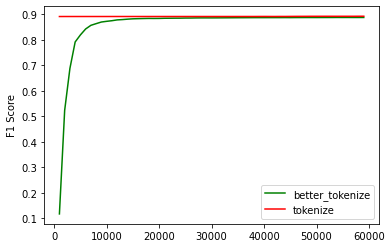

In [76]:
plt.plot([1000*i for i in range(1, len(f1_list_3) + 1)], f1_list_3, color='green', label='better_tokenize')
plt.plot([1000*i for i in range(1, len(f1_list_10) + 1)], f1_list_10, color='red', label='tokenize')
plt.legend()
plt.ylabel('F1 Score')
plt.savefig('tokenize-f1.png', dpi=100, bbox_inches='tight')
plt.show()

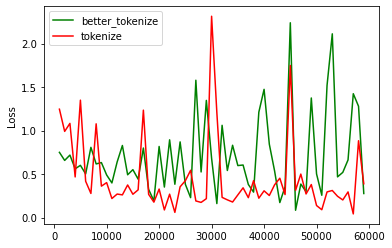

In [77]:
plt.plot([1000*i for i in range(1, len(loss_list_3) + 1)], loss_list_3, color='green', label='better_tokenize')
plt.plot([1000*i for i in range(1, len(loss_list_10) + 1)], loss_list_10, color='red', label='tokenize')
plt.legend()
plt.ylabel('Loss')
plt.savefig('tokenize-loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [22]:
newPytorch = pytorchModule(d=20, l_r=1e-6, w_d=0.001, opt="RMSprop")
newPytorch.load('./new_logistic_regrssion.pth')
print(newPytorch.eval(X_val, Y_val))

0.9708707928657532


In [23]:
newPytorch = pytorchModule(d=20, l_r=1e-6, w_d=0.001, opt="RMSprop")
newPytorch.load('./new_logistic_regrssion.pth')
with torch.no_grad():
    Y_pred = newPytorch.model(X_test)
    Y_pred_class = Y_pred.round()

with open('pred_class.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['uid_email', 'party_affiliation'])
    for i in range(len(Y_pred_class)):
        if Y_pred_class[i].sum().item() == 0:
            csvwriter.writerow([uid[i], 'Democratic Party'])
        else:
            csvwriter.writerow([uid[i], 'Republican Party'])
